# ResNet-50 with Neutrino Dataset

### Importing essential libraries
this will be cleaned, some are inessential

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [3]:
import sklearn
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

I check here if cuda gpu is available

In [4]:
torch.cuda.is_available()

True

## Model, Train, and Test

I define here the model (ResNet-50) and the train and test function. The model takes as input images channel first with 3 channels. The test definition is week and it could lead to a memory leak. 

In [5]:
#pred_list and target_list are two lists of cuda tensors containing respectively the predictions and the 
#target values. Each tensor will be test_batch_size in lenght. Each list will contain 
#(amount of test samples/test_batch_size)*epochs samples. E.g. with 10k test samples, test_batch_size = 1k and
#4 epochs you'll get a list of 40 elements, each element 1k. Further down these lists will be converted in arrays.

pred_list = []
target_list = []
accuracy = []
loss = []
epochs = 10
test_batch = 100
###############################################################    
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(Bottleneck, [3,4,6,3], num_classes=3)
        self.conv1 = torch.nn.Conv2d(3, 64,
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)
######if you then use nll_loss you have to use log_sotmax        
    def forward(self, x):
        return F.log_softmax(
            super(MnistResNet, self).forward(x), dim=-1)
    
##############################################    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, 1000)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

####################################################################################        



def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        output = None
        del output
        target = None
        del target
        length = len(data)
        data = None
        del data
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * length, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            data = None
            del data
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            pred_list.append(pred)
            target_list.append(target)
            output = None
            del output
            pred = None
            del pred
            
            
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    accuracy.append(100. * correct / len(test_loader.dataset))
    loss.append(test_loss)

## Dataset

I implemented here a simple dataset. At the moment, it takes a tensor as data and numpy array as target. Moreover, it only takes one file. This is something that I will need to change in the future since we have several files.

In [6]:
#implementing DataSet

class NeutrinoDataset(Dataset):
    """The training table dataset.
    """
    def __init__(self, x_tensor, y_tensor):
        #x_filenames = glob(x_path + '*.png') # Get the filenames of all training images
        
        #self.x_data = [torch.from_numpy(misc.imread(filename)) for filename in x_filenames] # Load the images into torch tensors
        #self.y_data = target_label_list # Class labels
        self.x_data = x_tensor
        self.y_data = y_tensor
        self.len = len(self.x_data)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__(self):
        return self.len

In [7]:
x_train_temp_0 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_numu_500_0.npy')
y_train_0 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_numu_500_event_0.npy')

x_train_temp_1 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_numu_500_1.npy')
y_train_1 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_numu_500_event_1.npy')

x_train_temp_2 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_numu_500_2.npy')
y_train_2 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_numu_500_event_2.npy')

x_train_numu_3 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_numu_500_3.npy')
y_train_numu_3 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_numu_500_event_3.npy')

x_train_numu_4 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_numu_500_4.npy')
y_train_numu_4 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_numu_500_event_4.npy')

x_train_numu_5 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_numu_500_5.npy')
y_train_numu_5 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_numu_500_event_5.npy')

x_train_numu_6 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_numu_500_6.npy')
y_train_numu_6 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_numu_500_event_6.npy')

x_train_numu_7 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_numu_500_7.npy')
y_train_numu_7 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_numu_500_event_7.npy')

x_train_temp_3 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_nue_500_0.npy')
y_train_3 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_nue_500_event_0.npy')

x_train_temp_4 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_nue_500_1.npy')
y_train_4 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_nue_500_event_1.npy')

x_train_temp_5 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_nue_500_2.npy')
y_train_5 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_nue_500_event_2.npy')

x_train_temp_6 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_nue_500_3.npy')
y_train_6 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_nue_500_event_3.npy')

x_train_nue_4 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_nue_500_4.npy')
y_train_nue_4 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_nue_500_event_4.npy')

x_train_nue_5 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_nue_500_5.npy')
y_train_nue_5 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_nue_500_event_5.npy')

x_train_nue_6 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_nue_500_6.npy')
y_train_nue_6 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_nue_500_event_6.npy')

x_train_nue_7 = np.load('/home/stefano/neutrino/data/final_array_x/train/x_train_nue_500_7.npy')
y_train_nue_7 = np.load('/home/stefano/neutrino/data/final_array_y/train/y_train_nue_500_event_7.npy')
                         
x_test_temp_0 = np.load('/home/stefano/neutrino/data/final_array_x/test/x_test_numu_500_0.npy')
y_test_0 = np.load('/home/stefano/neutrino/data/final_array_y/test/y_test_numu_500_event_0.npy')

x_test_temp_1 = np.load('/home/stefano/neutrino/data/final_array_x/test/x_test_nue_500_0.npy')
y_test_1 = np.load('/home/stefano/neutrino/data/final_array_y/test/y_test_nue_500_event_0.npy')
    

#concatenate all the files together and then delete from the memory unnecessary files
x_train_temp_a=np.concatenate((x_train_temp_0, x_train_temp_1))
x_train_temp_b=np.concatenate((x_train_temp_a, x_train_temp_2))
x_train_temp_0 = None
del x_train_temp_0
x_train_temp_1 = None
del x_train_temp_1
x_train_temp_2 = None
del x_train_temp_2
x_train_temp_a = None
del x_train_temp_a
x_train_temp_c=np.concatenate((x_train_temp_b, x_train_temp_3))
x_train_temp_b=None
del x_train_temp_b
x_train_temp_d=np.concatenate((x_train_temp_c, x_train_temp_4))
x_train_temp_c=None
del x_train_temp_c
x_train_temp_e=np.concatenate((x_train_temp_d, x_train_temp_5))
x_train_temp_3 = None
del x_train_temp_3
x_train_temp_4 = None
del x_train_temp_4
x_train_temp_5 = None
del x_train_temp_5
x_train_temp_d = None
del x_train_temp_d
x_train_temp_f=np.concatenate((x_train_temp_e, x_train_temp_6))
x_train_temp_e=None
del x_train_temp_e
x_train_temp_6 = None
del x_train_temp_6
x_train_temp_g=np.concatenate((x_train_temp_f, x_train_numu_3))
x_train_temp_f=None
del x_train_temp_f
x_train_numu_3 = None
del x_train_numu_3
x_train_temp_h=np.concatenate((x_train_temp_g, x_train_nue_4))
x_train_temp_g=None
del x_train_temp_g
x_train_nue_4 = None
del x_train_nue_4
x_train_temp_i=np.concatenate((x_train_temp_h, x_train_numu_4))
x_train_temp_h=None
del x_train_temp_h
x_train_numu_4 = None
del x_train_numu_4
x_train_temp_l=np.concatenate((x_train_temp_i, x_train_nue_5))
x_train_temp_i=None
del x_train_temp_i
x_train_nue_5 = None
del x_train_nue_5
x_train_temp_m=np.concatenate((x_train_temp_l, x_train_numu_5))
x_train_temp_l=None
del x_train_temp_l
x_train_numu_5 = None
del x_train_numu_5
x_train_temp_n=np.concatenate((x_train_temp_m, x_train_nue_6))
x_train_temp_m=None
del x_train_temp_m
x_train_nue_6 = None
del x_train_nue_6
x_train_temp_o=np.concatenate((x_train_temp_n, x_train_numu_6))
x_train_temp_n=None
del x_train_temp_n
x_train_numu_6 = None
del x_train_numu_6
x_train_temp_p=np.concatenate((x_train_temp_o, x_train_nue_7))
x_train_temp_o=None
del x_train_temp_o
x_train_nue_7 = None
del x_train_nue_7
x_train_temp=np.concatenate((x_train_temp_p, x_train_numu_7))
x_train_temp_p=None
del x_train_temp_p
x_train_numu_7 = None
del x_train_numu_7



x_test_temp=np.concatenate((x_test_temp_0, x_test_temp_1))
x_test_temp_0 = None
del x_test_temp_0
x_test_temp_1 = None
del x_test_temp_1

y_train_a=np.concatenate((y_train_0, y_train_1))
y_train_0 = None
del y_train_0
y_train_1 = None
del y_train_1
y_train_b=np.concatenate((y_train_a, y_train_2))
y_train_c=np.concatenate((y_train_b, y_train_3))
y_train_a=None
del y_train_a
y_train_b=None
del y_train_b
y_train_d=np.concatenate((y_train_c, y_train_4))
y_train_c=None
del y_train_c
y_train_e=np.concatenate((y_train_d, y_train_5))
y_train_2 = None
del y_train_2
y_train_3 = None
del y_train_3
y_train_4 = None
del y_train_4
y_train_5 = None
del y_train_5
y_train_d=None
del y_train_d
y_train_f=np.concatenate((y_train_e, y_train_6))
y_train_e=None
del y_train_e
y_train_6 = None
del y_train_6
y_train_g=np.concatenate((y_train_f, y_train_numu_3))
y_train_f=None
del y_train_f
y_train_numu_3 = None
del y_train_numu_3
y_train_h=np.concatenate((y_train_g, y_train_nue_4))
y_train_g=None
del y_train_g
y_train_nue_4 = None
del y_train_nue_4
y_train_i=np.concatenate((y_train_h, y_train_numu_4))
y_train_h=None
del y_train_h
y_train_numu_4 = None
del y_train_numu_4
y_train_l=np.concatenate((y_train_i, y_train_nue_5))
y_train_i=None
del y_train_i
y_train_nue_5 = None
del y_train_nue_5
y_train_m=np.concatenate((y_train_l, y_train_numu_5))
y_train_l=None
del y_train_l
y_train_numu_5 = None
del y_train_numu_5
y_train_n=np.concatenate((y_train_m, y_train_nue_6))
y_train_m=None
del y_train_m
y_train_nue_6 = None
del y_train_nue_6
y_train_o=np.concatenate((y_train_n, y_train_numu_6))
y_train_n=None
del y_train_n
y_train_numu_6 = None
del y_train_numu_6
y_train_p=np.concatenate((y_train_o, y_train_nue_7))
y_train_o=None
del y_train_o
y_train_nue_7 = None
del y_train_nue_7
y_train=np.concatenate((y_train_p, y_train_numu_7))
y_train_p=None
del y_train_p
y_train_numu_7 = None
del y_train_numu_7



y_test=np.concatenate((y_test_0, y_test_1))
y_test_0 = None
del y_test_0
y_test_1 = None
del y_test_1

print('x_train_temp.shape',x_train_temp.shape)
print('x_test_temp.shape',x_test_temp.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)


x_train_temp.shape (8000, 200, 200, 3)
x_test_temp.shape (1000, 200, 200, 3)
y_train.shape (8000,)
y_test.shape (1000,)


## Importing files and preparing the dataset

In this part I import the train and test files, I normalize them and I reshape them to be channel first. This part could also lead to potential memory leaks. It would be nice to convert and normalise the numpy array in one go, but at the moment I can't.

In [ ]:
###this method is broken!!! do not use until fixed

import os

folder_x_train='/home/stefano/neutrino/data/final_array_x/train/'
directory_x_train=os.fsencode(folder_x_train)

folder_x_test='/home/stefano/neutrino/data/final_array_x/test/'
directory_x_test=os.fsencode(folder_x_test)

folder_y_train='/home/stefano/neutrino/data/final_array_y/train/'
directory_y_train=os.fsencode(folder_y_train)

folder_y_test='/home/stefano/neutrino/data/final_array_y/test/'
directory_y_test=os.fsencode(folder_y_test)

counter_a=0
counter_b=0
counter_c=0
counter_d=0

for file in os.listdir(directory_x_train):
    x_train=np.load(folder_x_train+os.fsdecode(file))
    if counter_a==0:
        x_train_temp=x_train
    elif counter_a>0:
        x_train_temp=np.concatenate((x_train_temp,x_train))
        
    counter_a=counter_a+1
    del x_train
        
for file in os.listdir(directory_x_test):
    x_test=np.load(folder_x_test+os.fsdecode(file))
    if counter_b==0:
        x_test_temp=x_test
    elif counter_b>0:
        x_test_temp=np.concatenate((x_test_temp,x_test))
        
    counter_b=counter_b+1
    del x_test

for file in os.listdir(directory_y_train):
    y_tr=np.load(folder_y_train+os.fsdecode(file))
    if counter_c==0:
        y_train=y_tr
    elif counter_c>0:
        y_train=np.concatenate((y_train,y_tr))
        
    counter_c=counter_c+1
    del y_tr
    
for file in os.listdir(directory_y_test):
    y_ts=np.load(folder_y_test+os.fsdecode(file))
    if counter_d==0:
        y_test=y_ts
    elif counter_d>0:
        y_test=np.concatenate((y_test,y_ts))
        
    counter_d=counter_d+1
    del y_ts
    
print(x_train_temp.shape)
print(x_test_temp.shape)
print(y_train.shape)
print(y_test.shape)

del counter_a
del counter_b
del counter_c
del counter_d

In [8]:
#passages are: x_train_temp -> x_train (min 0 max 1, float32) -> x_train_reshaped (channel first) -> x_train_tensor

#normalise the data
old_min = np.min(x_train_temp)
old_max = np.max(x_train_temp)
print("Before:", old_min, old_max)
x_train = x_train_temp.astype('float32')
x_test = x_test_temp.astype('float32')
x_train /=255
x_test /= 255
new_min = np.min(x_train)
new_max = np.max(x_train)
print("After:", new_min, new_max)

print("Test Data Shape after conversion to float")
    
    #read the dimensions from one example in the trainig set
img_rows, img_cols = x_train[0].shape[0], x_train[0].shape[1]
print(x_train[0].shape[0])
print(x_train[0].shape[1])

#read the dimensions from one example in the trainig set
img_rows, img_cols = x_train[0].shape[0], x_train[0].shape[1]

#Different NN libraries (e.g., TF) use different ordering of dimensions
#Here we set the "input shape" so that later the NN knows what shape to expect
x_train_reshaped = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
x_test_reshaped = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
input_shape = (3, img_rows, img_cols)

print("input_shape",input_shape)
print("x_train[0].shape[0]", x_train_reshaped[0].shape[0])
print("x_train[0].shape[1]", x_train_reshaped[0].shape[1])
print("x_train[0].shape[2]", x_train_reshaped[0].shape[2])
print("x_train.shape",x_train.shape)

x_train_tensor = torch.from_numpy(x_train_reshaped).float()
x_test_tensor = torch.from_numpy(x_test_reshaped).float()

x_train = None
del x_train
x_test = None
del x_test
x_train_reshaped = None
del x_train_reshaped
x_test_reshaped = None
del x_test_reshaped

y_train_tensor=torch.from_numpy(y_train)
y_test_tensor=torch.from_numpy(y_test)

#y_train = None
#del y_train
#y_test = None
#del y_test

dataset_test = NeutrinoDataset(x_test_tensor, y_test_tensor)

Before: 0 255
After: 0.0 1.0
Test Data Shape after conversion to float
200
200
input_shape (3, 200, 200)
x_train[0].shape[0] 3
x_train[0].shape[1] 200
x_train[0].shape[2] 200
x_train.shape (8000, 200, 200, 3)


## Definition of main function

I define here the dataset and the main function. This seems to be the stronger part of the code.

In [9]:
import easydict
def main():
    args = easydict.EasyDict({
        "batch_size": 16,#it was 64
        "test_batch_size": test_batch,
        "epochs": epochs,
        "lr": 1.0,
        "gamma": 0.7,
        "no_cuda": False,
        "seed": 1,
        "log_interval":10,
        "save_model": False
    })
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
    #device = torch.device("cpu")
    
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    
    dataset_train = NeutrinoDataset(x_train_tensor, y_train_tensor)
    dataset_test = NeutrinoDataset(x_test_tensor, y_test_tensor)
    
    train_loader = torch.utils.data.DataLoader(dataset=dataset_train,
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset_test,
        batch_size=args.test_batch_size, shuffle=False, **kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


### Plotting your Train and Test Dataset
It is important to always check your dataset. With the following lines images from your train and test dataset and randomly selected and plotted.

In this part I calcolate mean and std of the pics in case I find a way to use tensor.normalise. Skip this part when run the code.

## Visualisation

The following two cells contain a cool tool to visualise train and test dataset. Useful.

(8000, 200, 200, 3)
now showing image  3327


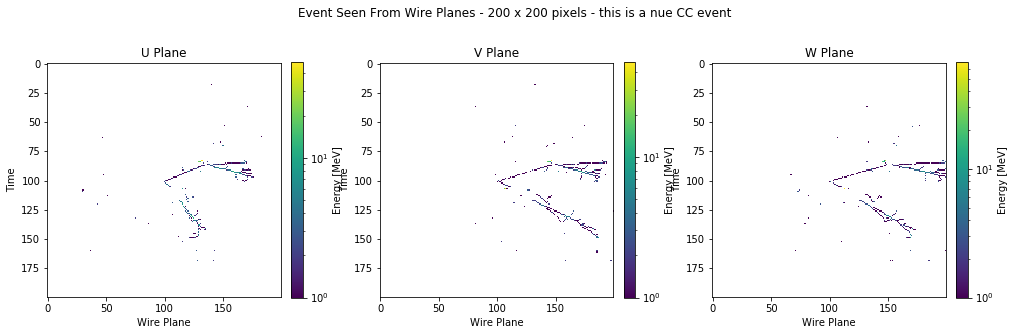

In [10]:
use_cuda =  torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
import zlib
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
figsize = [14, 5]
starting_number = torch.IntTensor.item(torch.LongTensor(1).random_(0, len(x_train_temp)-1))#-(nrows*ncols)))

print(x_train_temp.shape)
#if use_cuda == True:
#    x_train_cpu=x_train_temp.cpu()
#    y_train_cpu=y_train_tensor.cpu()
#else:
#    x_train_cpu=x_train_temp
#    y_train_cpu=y_train_tensor
    
print("now showing image ",(starting_number))

####this part is for the true value
#0 is for NC events
#1 is for numu CC events
#2 is for nue CC events
truth=y_train[starting_number]
if truth==0:
    truth_stg="NC"
elif truth==1:
    truth_stg="numu CC"
elif truth==2:
    truth_stg="nue CC"

a = x_train_temp[(starting_number),:,:,0]

b = x_train_temp[(starting_number),:,:,1]

c = x_train_temp[(starting_number),:,:,2]


f, axarr = plt.subplots(1,3,figsize=figsize)#, constrained_layout=True)
f.suptitle('Event Seen From Wire Planes - 200 x 200 pixels - this is a '+truth_stg+' event')
im=axarr[0].imshow(a, norm=matplotlib.colors.LogNorm())
im2=axarr[1].imshow(b, norm=matplotlib.colors.LogNorm())
im3=axarr[2].imshow(c, norm=matplotlib.colors.LogNorm())
axarr[0].set_title('U Plane')
axarr[1].set_title('V Plane')
axarr[2].set_title('W Plane')
bar1=f.colorbar(im,ax=axarr[0],fraction=0.046,pad=0.04)
bar2=f.colorbar(im2,ax=axarr[1],fraction=0.046,pad=0.04)
bar3=f.colorbar(im3,ax=axarr[2],fraction=0.046,pad=0.04)
bar1.set_label('Energy [MeV]')
bar2.set_label('Energy [MeV]')
bar3.set_label('Energy [MeV]')
f.tight_layout() #this is to add more space between plots
for ax in axarr.flat:
    ax.set(xlabel='Wire Plane', ylabel='Time')

plt.show()
plt.close()


now showing image  898


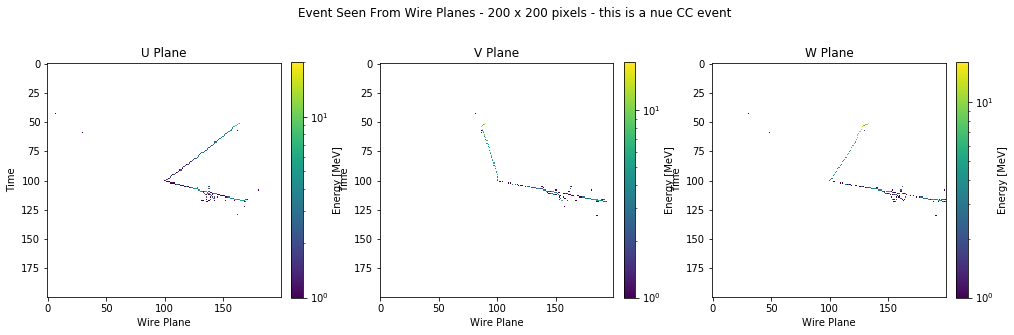

In [11]:
figsize = [14, 5]
starting_number = torch.IntTensor.item(torch.LongTensor(1).random_(0, len(x_test_temp)-1))#-(nrows*ncols)))
    
print("now showing image ",(starting_number))

####this part is for the true value
#0 is for NC events
#1 is for numu CC events
#2 is for nue CC events
truth=y_test[starting_number]
if truth==0:
    truth_stg="NC"
elif truth==1:
    truth_stg="numu CC"
elif truth==2:
    truth_stg="nue CC"

a = x_test_temp[(starting_number),:,:,0]

b = x_test_temp[(starting_number),:,:,1]

c = x_test_temp[(starting_number),:,:,2]


f, axarr = plt.subplots(1,3,figsize=figsize)#, constrained_layout=True)
f.suptitle('Event Seen From Wire Planes - 200 x 200 pixels - this is a '+truth_stg+' event')
im=axarr[0].imshow(a, norm=matplotlib.colors.LogNorm())
im2=axarr[1].imshow(b, norm=matplotlib.colors.LogNorm())
im3=axarr[2].imshow(c, norm=matplotlib.colors.LogNorm())
axarr[0].set_title('U Plane')
axarr[1].set_title('V Plane')
axarr[2].set_title('W Plane')
bar1=f.colorbar(im,ax=axarr[0],fraction=0.046,pad=0.04)
bar2=f.colorbar(im2,ax=axarr[1],fraction=0.046,pad=0.04)
bar3=f.colorbar(im3,ax=axarr[2],fraction=0.046,pad=0.04)
bar1.set_label('Energy [MeV]')
bar2.set_label('Energy [MeV]')
bar3.set_label('Energy [MeV]')
f.tight_layout() #this is to add more space between plots
for ax in axarr.flat:
    ax.set(xlabel='Wire Plane', ylabel='Time')

plt.show()
plt.close()

In [12]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

## Main Run


In [13]:
start.record()
main()
end.record()

Train Epoch: 1 [0/8000 (0%)]	Loss: 6.799190
Train Epoch: 1 [160/8000 (2%)]	Loss: 1.229175
Train Epoch: 1 [320/8000 (4%)]	Loss: 0.998445
Train Epoch: 1 [480/8000 (6%)]	Loss: 0.860979
Train Epoch: 1 [640/8000 (8%)]	Loss: 0.918226
Train Epoch: 1 [800/8000 (10%)]	Loss: 1.536279
Train Epoch: 1 [960/8000 (12%)]	Loss: 1.020978
Train Epoch: 1 [1120/8000 (14%)]	Loss: 0.760909
Train Epoch: 1 [1280/8000 (16%)]	Loss: 1.176921
Train Epoch: 1 [1440/8000 (18%)]	Loss: 0.655631
Train Epoch: 1 [1600/8000 (20%)]	Loss: 1.001672
Train Epoch: 1 [1760/8000 (22%)]	Loss: 0.770306
Train Epoch: 1 [1920/8000 (24%)]	Loss: 0.610217
Train Epoch: 1 [2080/8000 (26%)]	Loss: 0.707711
Train Epoch: 1 [2240/8000 (28%)]	Loss: 0.831842
Train Epoch: 1 [2400/8000 (30%)]	Loss: 0.847890
Train Epoch: 1 [2560/8000 (32%)]	Loss: 0.664984
Train Epoch: 1 [2720/8000 (34%)]	Loss: 0.844488
Train Epoch: 1 [2880/8000 (36%)]	Loss: 1.118905
Train Epoch: 1 [3040/8000 (38%)]	Loss: 0.755615
Train Epoch: 1 [3200/8000 (40%)]	Loss: 1.427363
Train 

Train Epoch: 4 [3040/8000 (38%)]	Loss: 0.334770
Train Epoch: 4 [3200/8000 (40%)]	Loss: 0.613634
Train Epoch: 4 [3360/8000 (42%)]	Loss: 0.561091
Train Epoch: 4 [3520/8000 (44%)]	Loss: 0.952903
Train Epoch: 4 [3680/8000 (46%)]	Loss: 0.324880
Train Epoch: 4 [3840/8000 (48%)]	Loss: 0.213197
Train Epoch: 4 [4000/8000 (50%)]	Loss: 0.750899
Train Epoch: 4 [4160/8000 (52%)]	Loss: 0.365135
Train Epoch: 4 [4320/8000 (54%)]	Loss: 0.243158
Train Epoch: 4 [4480/8000 (56%)]	Loss: 0.555660
Train Epoch: 4 [4640/8000 (58%)]	Loss: 0.294657
Train Epoch: 4 [4800/8000 (60%)]	Loss: 0.374373
Train Epoch: 4 [4960/8000 (62%)]	Loss: 0.552626
Train Epoch: 4 [5120/8000 (64%)]	Loss: 0.641177
Train Epoch: 4 [5280/8000 (66%)]	Loss: 0.261035
Train Epoch: 4 [5440/8000 (68%)]	Loss: 0.442295
Train Epoch: 4 [5600/8000 (70%)]	Loss: 0.570917
Train Epoch: 4 [5760/8000 (72%)]	Loss: 0.205517
Train Epoch: 4 [5920/8000 (74%)]	Loss: 0.604522
Train Epoch: 4 [6080/8000 (76%)]	Loss: 0.507341
Train Epoch: 4 [6240/8000 (78%)]	Loss: 0

Train Epoch: 7 [5920/8000 (74%)]	Loss: 0.022940
Train Epoch: 7 [6080/8000 (76%)]	Loss: 0.030054
Train Epoch: 7 [6240/8000 (78%)]	Loss: 0.096558
Train Epoch: 7 [6400/8000 (80%)]	Loss: 0.029462
Train Epoch: 7 [6560/8000 (82%)]	Loss: 0.086736
Train Epoch: 7 [6720/8000 (84%)]	Loss: 0.038028
Train Epoch: 7 [6880/8000 (86%)]	Loss: 0.104634
Train Epoch: 7 [7040/8000 (88%)]	Loss: 0.347692
Train Epoch: 7 [7200/8000 (90%)]	Loss: 0.092007
Train Epoch: 7 [7360/8000 (92%)]	Loss: 0.127300
Train Epoch: 7 [7520/8000 (94%)]	Loss: 0.031117
Train Epoch: 7 [7680/8000 (96%)]	Loss: 0.465723
Train Epoch: 7 [7840/8000 (98%)]	Loss: 0.191259

Test set: Average loss: 1.2060, Accuracy: 725/1000 (72%)

Train Epoch: 8 [0/8000 (0%)]	Loss: 0.013405
Train Epoch: 8 [160/8000 (2%)]	Loss: 0.014756
Train Epoch: 8 [320/8000 (4%)]	Loss: 0.052260
Train Epoch: 8 [480/8000 (6%)]	Loss: 0.029571
Train Epoch: 8 [640/8000 (8%)]	Loss: 0.024586
Train Epoch: 8 [800/8000 (10%)]	Loss: 0.048088
Train Epoch: 8 [960/8000 (12%)]	Loss: 0.22

In [21]:
print(start.elapsed_time(end))

471221.09375


In [ ]:
#resnet50 size 200x200 with cpu (25-02-2020) batch size 1
# with cpu is was 3717510.25 ms, that is ~3717 s ~ 1 h for 6 epochs - final test set batch size 1
# Test set: Average loss: 3.5087, Accuracy: 487/1000 (49%)

#resnet50 size 200x200 with gpu (25-02-2020) batch size 1
# with gpu is was 381100.1875 ms, that is ~381 s ~ 6 and a half min for 6 epochs - final test set batch size 1
# Test set: Average loss: 2.9999, Accuracy: 499/1000 (50%)

#resnet50 size 200x200 with gpu (25-02-2020) batch size 16
# with gpu is was 329710.28125 ms, that is ~329 s ~ 5 min for 20 epochs - final test set batch size 100
# Test set: Average loss: 1.2409, Accuracy: 664/1000 (66%)

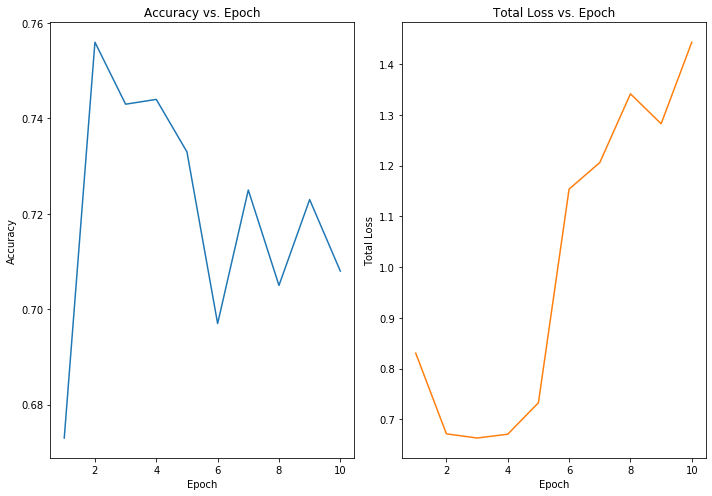

In [15]:
epochs_array = []
for i in range (1,epochs+1):
    epochs_array.append(i)
    
accuracy=np.array(accuracy)
accuracy=accuracy/100
epochs_array = np.array(epochs_array)
loss = np.array(loss)
plt.figure(figsize = (10,7))
plt.subplot(1, 2, 1)
plt.title('Accuracy vs. Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_array,accuracy)
plt.subplot(1, 2, 2)
plt.title('Total Loss vs. Epoch')
plt.ylabel('Total Loss')
plt.xlabel('Epoch')
plt.plot(epochs_array,loss,color='C1')
plt.tight_layout()

plt.show()



In [16]:
pred_array_total = [] # array containing all predictions for all epochs
pred_array = [] #array containing only predictions of last epoch
for i in range(len(pred_list)):
    pred_array_total.append(pred_list[i].cpu().numpy())
    
pred_array_total=np.array(pred_array_total)
pred_array_total=np.squeeze(np.concatenate(pred_array_total))
#print(epochs*test_batch)
for i in range ((epochs*(1000)-1000),(epochs*1000)):
    pred_array.append(pred_array_total[i])
    
pred_array=np.array(pred_array)
pred_array.shape

(1000,)

In [17]:
target_array_total = []#array containing all the targets for all epochs
target_array = []#array containing targets for last epoch
for i in range(len(target_list)):
    target_array_total.append(target_list[i].cpu().numpy())
    
target_array_total=np.array(target_array_total)
target_array_total=np.squeeze(np.concatenate(target_array_total))

for i in range ((epochs*1000)-1000,epochs*1000):
    target_array.append(target_array_total[i])
    
target_array=np.array(target_array)
target_array.shape

(1000,)

This was supposed to be  NC  but it was predicted as  nue CC


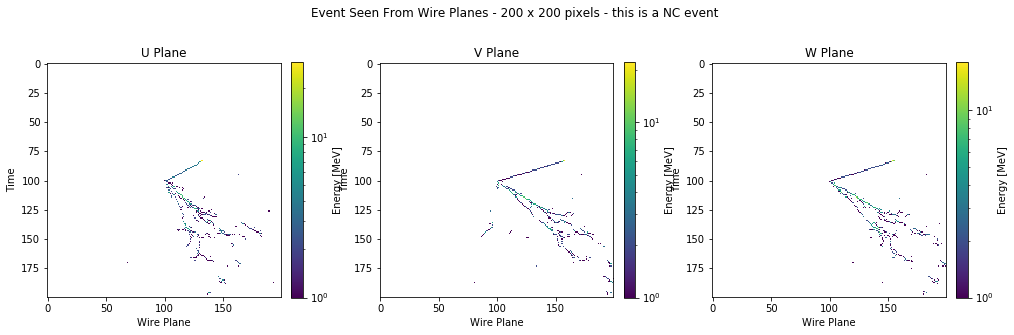

In [18]:
import random
wrong_list = []
for i in range(len(target_array)):
    if target_array[i]!=pred_array[i]:
        wrong_list.append(i)
        
element=random.choice(wrong_list)

####this part is for the true value
#0 is for NC events
#1 is for numu CC events
#2 is for nue CC events
truth_check=y_test[element]
if truth_check==0:
    truth_stg="NC"
elif truth_check==1:
    truth_stg="numu CC"
elif truth_check==2:
    truth_stg="nue CC"
    
if pred_array[element]==0:
    pred_stg="NC"
elif pred_array[element]==1:
    pred_stg="numu CC"
elif pred_array[element]==2:
    pred_stg="nue CC"

#print('This was supposed to be ',target_array[element],' but it was predicted as ',pred_array[element])
print('This was supposed to be ',truth_stg,' but it was predicted as ',pred_stg)

a = x_test_temp[(element),:,:,0]

b = x_test_temp[(element),:,:,1]

c = x_test_temp[(element),:,:,2]


f, axarr = plt.subplots(1,3,figsize=figsize)#, constrained_layout=True)
f.suptitle('Event Seen From Wire Planes - 200 x 200 pixels - this is a '+truth_stg+' event')
im=axarr[0].imshow(a, norm=matplotlib.colors.LogNorm())
im2=axarr[1].imshow(b, norm=matplotlib.colors.LogNorm())
im3=axarr[2].imshow(c, norm=matplotlib.colors.LogNorm())
axarr[0].set_title('U Plane')
axarr[1].set_title('V Plane')
axarr[2].set_title('W Plane')
bar1=f.colorbar(im,ax=axarr[0],fraction=0.046,pad=0.04)
bar2=f.colorbar(im2,ax=axarr[1],fraction=0.046,pad=0.04)
bar3=f.colorbar(im3,ax=axarr[2],fraction=0.046,pad=0.04)
bar1.set_label('Energy [MeV]')
bar2.set_label('Energy [MeV]')
bar3.set_label('Energy [MeV]')
f.tight_layout() #this is to add more space between plots
for ax in axarr.flat:
    ax.set(xlabel='Wire Plane', ylabel='Time')

In [19]:
from __future__ import print_function
torch.set_printoptions(linewidth = 120)
import sklearn
#print(sklearn.__version__)
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix


plt.figure(figsize=(50,50))
cm=sklearn.metrics.confusion_matrix(target_array, pred_array,normalize='all')#, classes=label_dict,
                     #title='Confusion matrix')
cm
#plt.show()

array([[0.122, 0.09 , 0.011],
       [0.036, 0.316, 0.026],
       [0.029, 0.1  , 0.27 ]])

<Figure size 3600x3600 with 0 Axes>

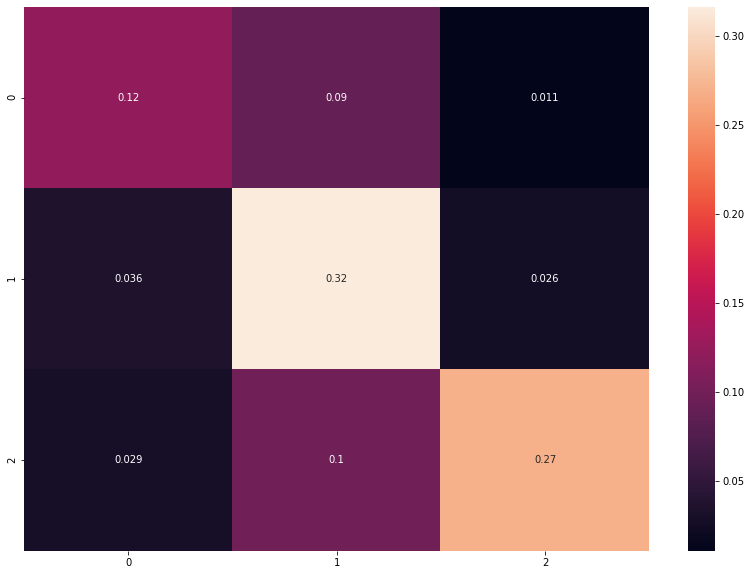

In [20]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(cm, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (14,10))
sn.heatmap(df_cm, annot=True)